In [1]:
import pandas as pd
import numpy as np

# 讀取4月份的資料
data = pd.read_csv(('sraapril.csv'), parse_dates=['transaction_date'])

# 選擇交易日期、產品編號、數量
data = data[['transaction_date', 'product_id', 'quantity']]

# 將資料按照交易日期排列
data = data.sort_values(by='transaction_date')

# 將資料表的index設定成交易日期
data = data.set_index('transaction_date')

# 挑選資料表內，product_id為75, 71, 73的rows
data_apr = data.loc[data['product_id'].isin([69, 74, 76])]
# 以日期欄位作為群組依據，計算每天的銷售量
daily_sales = data_apr.groupby('transaction_date')['quantity'].sum()
april_daily_sales = pd.DataFrame(daily_sales)

In [2]:
# 讀取5月份的資料
data = pd.read_csv(('sramay.csv'), parse_dates=['transaction_date'])

# 選擇交易日期、產品編號、數量
data = data[['transaction_date', 'product_id', 'quantity']]

# 將資料按照交易日期排列
data = data.sort_values(by='transaction_date')

# 將資料表的index設定成交易日期
data = data.set_index('transaction_date')

# 挑選資料表內，product_id為75, 71, 73的rows
data_may = data.loc[data['product_id'].isin([69, 74, 76])]

# 以日期欄位作為群組依據，計算每天的銷售量
daily_sales = data_may.groupby('transaction_date')['quantity'].sum()
may_daily_sales = pd.DataFrame(daily_sales)

In [3]:
data = pd.concat([april_daily_sales, may_daily_sales], ignore_index=True, axis = 1)

In [4]:
print(data)
print(type(data))

                     0     1
transaction_date            
2019-04-01        44.0   NaN
2019-04-02        41.0   NaN
2019-04-03        44.0   NaN
2019-04-04        38.0   NaN
2019-04-05        34.0   NaN
...                ...   ...
2019-05-27         NaN  20.0
2019-05-28         NaN  12.0
2019-05-29         NaN  21.0
2019-05-30         NaN  12.0
2019-05-31         NaN  16.0

[61 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>


In [5]:
# 提取非空資料
april_data = data[0].dropna()
may_data = data[1].dropna()

# 使用 pd.concat() 合併資料
merged_df = pd.concat([april_data, may_data], axis=0)

# 轉換為 (61, 1) 的 DataFrame
merged_df = merged_df.to_frame()


In [6]:
merged_df

,0
transaction_date,
2019-04-01,44.0
2019-04-02,41.0
2019-04-03,44.0
2019-04-04,38.0
2019-04-05,34.0
...,...
2019-05-27,20.0
2019-05-28,12.0
2019-05-29,21.0


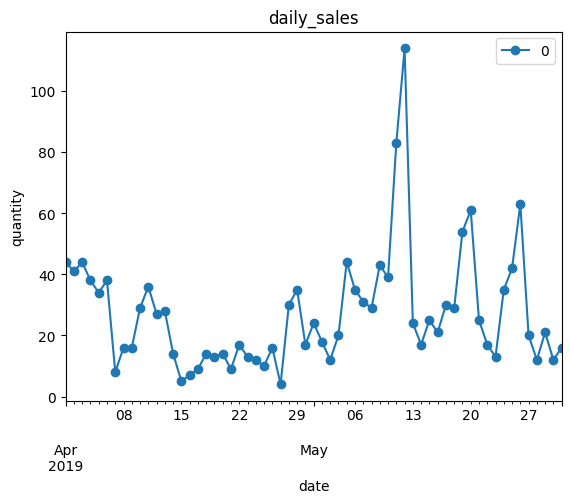

In [7]:
import matplotlib.pyplot as plt
# 繪製折線圖
merged_df.plot(kind='line', use_index=True, marker='o')

# 設置圖形標題和軸標籤
plt.title('daily_sales')
plt.xlabel('date')
plt.ylabel('quantity')

# 顯示圖形
plt.show()

In [8]:
from sklearn.preprocessing import MinMaxScaler
# 將數據歸一化
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(merged_df)

In [9]:
def GetDataAndLabel(data,TimeStep):
    trainData, trainLabel = [], []
    for i in range(len(data)-TimeStep):
        trainData.append(data[i:(i+TimeStep),0])
        trainLabel.append(data[i+TimeStep,0])
    return np.array(trainData), np.array(trainLabel)

In [10]:
# 將資料切割成訓練集與測試集, 分割比例為 7:3
TrainDataNum = int(len(data) * 0.7)
TestDataNum = len(data) - TrainDataNum
# 前面 0~ TrainDataNum-1 的資料為訓練集
trainData = data[0:TrainDataNum,:]
# 從 TrainDataNum 之後的資料為測試集
testData = data[TrainDataNum:len(data),:]
print(trainData.shape)
print(testData.shape)
TimeStep = 4
traindataNew, trainLabelNew = GetDataAndLabel(trainData, TimeStep)
testdataNew, testLabelNew = GetDataAndLabel(testData, TimeStep)
print("traindataNew.shape :",traindataNew.shape)
print("trainLabelNew.shape :",trainLabelNew.shape)
print("testdataNew.shape :",testdataNew.shape)
print("testLabelNew.shape :",testLabelNew.shape)

(42, 1)
(19, 1)
traindataNew.shape : (38, 4)
trainLabelNew.shape : (38,)
testdataNew.shape : (15, 4)
testLabelNew.shape : (15,)


In [11]:
# 將訓練資料與測試資料的維度改為 [batch_size, time_steps, input_dim]
traindataNew = np.reshape(traindataNew,
              (traindataNew.shape[0], traindataNew.shape[1], 1))
testdataNew = np.reshape(testdataNew,
              (testdataNew.shape[0], testdataNew.shape[1], 1))
print("traindataNew.shape :",traindataNew.shape)
print("testdataNew.shape :",testdataNew.shape)

traindataNew.shape : (38, 4, 1)
testdataNew.shape : (15, 4, 1)


In [12]:
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU
from tensorflow import keras
from tensorflow.keras import regularizers
model = keras.Sequential()
model.add(GRU(220,input_shape=(TimeStep,1), return_sequences=True, kernel_initializer='he_normal'))
model.add(Dropout(0.5))
model.add(GRU(110,input_shape=(TimeStep,1),return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 4, 220)            147180    
                                                                 
 dropout (Dropout)           (None, 4, 220)            0         
                                                                 
 gru_1 (GRU)                 (None, 110)               109560    
                                                                 
 dropout_1 (Dropout)         (None, 110)               0         
                                                                 
 dense (Dense)               (None, 1)                 111       
                                                                 
Total params: 256,851
Trainable params: 256,851
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
input_names = model.input_names
print(input_names)

['gru_input']


In [14]:
# 模型建立與訓練
from keras import callbacks
callback = callbacks.EarlyStopping(monitor='loss', patience=30)
opt = keras.optimizers.Adam(learning_rate=0.004)
model.compile(loss='mean_squared_error',
              optimizer=opt)
hist = model.fit(traindataNew,trainLabelNew,
                 epochs=300, batch_size=4, callbacks=[callback],verbose=0)

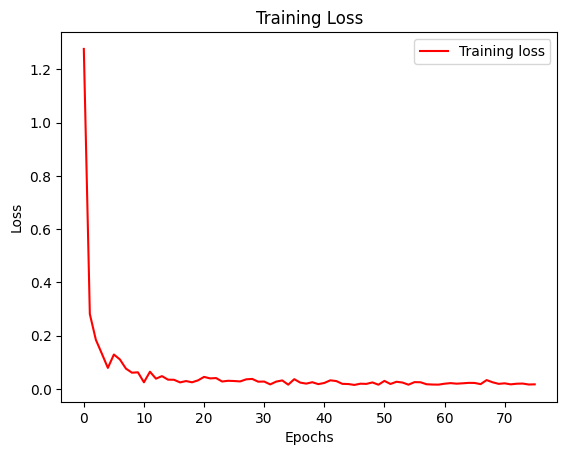

In [15]:
# 繪出每個訓練周期的損失值
loss = hist.history["loss"]
epochs = range(len(loss))
plt.plot(epochs,loss,'r-',label="Training loss")
plt.title('Training Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [16]:
trainPredict = model.predict(traindataNew)
testPredict = model.predict(testdataNew)
print(trainPredict.shape)
print(testPredict.shape)

1/1 [==============================] - 0s 15ms/step
(38, 1)
(15, 1)


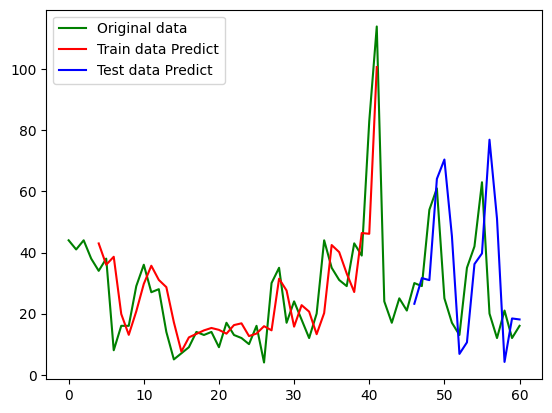

In [17]:
# 將預測資料轉換為原始資料
trainRealPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainLabelNew])
testRealPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testLabelNew])

# 創造一個與原始資料一樣的陣列,
PredtrainingData = np.empty_like(data)
PredtestData = np.empty_like(data)

# 將內部資料設定成 None (空類型)
originaldata = scaler.inverse_transform(data)
PredtrainingData[:, :] = np.nan
PredtestData[:, :] = np.nan
# 訓練集的預測資料是從 TimeStep 時間開始,
# 一直到 len(trainPredict) + TimeStep 結束
PredtrainingData[TimeStep:
             len(trainPredict) + TimeStep, :] = trainRealPredict
# 測試集的預測資料是從訓練集的長度 + (TimeStep * 2)時間開始,
# 一直到 len(trainPredict)結束
PredtestData[len(trainPredict) + (TimeStep * 2):
         len(data), :] = testRealPredict
# 繪製原始資料
plt.plot(originaldata,color = 'green',label="Original data")
# 繪製訓練集的預測資料
plt.plot(PredtrainingData, color = 'red',label="Train data Predict")
# 繪製測試集的預測資料
plt.plot(PredtestData, color = 'blue',label="Test data Predict")
plt.legend()
plt.show()

In [18]:
import tensorflow as tf
mse = tf.keras.losses.MeanSquaredError()
loss = mse(data[-15:], np.round(testPredict))
print("MSE: ", loss.numpy())

MSE:  0.16564187


In [19]:
# model.save('./GRU_V1_Biscotti_2.h5')